# Association Rules Mining with MLxtend_library

Association analysis using the apriori algorithm and the MLxtend library on a large real-world dataset. It had to be reduced to approx. 2'900 most frequent products occuring in 142'000 transactions. As can be seen it is a heavy longtail-business.

The generation of the frequent itemsets took 2h on my laptop.

- [MLxtend documentation example](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) for generation of frequent item sets with Apriori algorithm
- [MLxtend documentation example](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) for Association Rules


**Data Sources:**

- `data/raw/sales_total.csv`: real transaction dataset for a B2B retailer.

**Changes**

- 2019-07-07: Start notebook
- 2019-07-10: Finish notebook


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Prepare-basic-data-structure" data-toc-modified-id="Prepare-basic-data-structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare basic data structure</a></span></li><li><span><a href="#Get-frequent-itemsets-with-Apriori-algorithm" data-toc-modified-id="Get-frequent-itemsets-with-Apriori-algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get frequent itemsets with Apriori algorithm</a></span></li><li><span><a href="#Generate-Association-Rules" data-toc-modified-id="Generate-Association-Rules-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate Association Rules</a></span></li></ul></div>

---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Specials
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
# Load data
transactions_raw = pd.read_csv('data/raw/sales_total.csv', parse_dates=['Fakturadatum'])

## Prepare basic data structure

**IMPORTANT:** Using MLxtnd this analysis requires that all the data for a transaction be included in 1 row and the items should be 1-hot encoded.

In [3]:
transactions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2835054 entries, 0 to 2835053
Data columns (total 12 columns):
Kunde           int64
Fakturadatum    datetime64[ns]
Faktura         int64
Pos             int64
Artikel         object
Unit Price      float64
pro             int64
ME              object
Menge           float64
ME.1            object
Nettowert       float64
Währg           object
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 259.6+ MB


In [4]:
transactions_raw.sample(2)

,Kunde,Fakturadatum,Faktura,Pos,Artikel,Unit Price,pro,ME,Menge,ME.1,Nettowert,Währg
369240,8536051,2017-04-12,91620470,6,9150641,4.65,1,SE,1.0,ST,4.65,CHF
1418248,8086528,2018-01-15,91930541,3,6710417,41.50,1,ST,7.0,ST,290.50,CHF


In [5]:
# Subset for 2018 data only
transactions_18_full = transactions_raw.loc[transactions_raw['Fakturadatum'].dt.year == 2018]
transactions_18_full = transactions_18_full[['Kunde', 'Fakturadatum', 'Artikel', 'Nettowert']]

# Check results
print("Number of positions:", len(transactions_18_full))
print("Number of unique products:", transactions_18_full['Artikel'].nunique())

Number of positions: 1446429
Number of unique products: 74126


In [6]:
"""Check distribution of artikel counts"""

artikel_18_agg = pd.DataFrame(transactions_18_full.groupby('Artikel').agg(
        {'Kunde' : 'count', 'Nettowert' : 'sum'}
        ).sort_values('Kunde', ascending=False).reset_index())

artikel_18_agg.columns = ['Artikel', 'Count', 'Nettowert']
                              
# Check results
display(artikel_18_agg.head(20))

print("Number of artikel with count of > 100:",
      len(artikel_18_agg.loc[artikel_18_agg['Count'] > 100]))

,Artikel,Count,Nettowert
0,6113401,4865,560214.81
1,6115230,3146,146084.18
2,5344305,2752,467518.60
3,ABLAENG,2749,14969.26
4,5059001,2190,89111.30
5,6603161,2181,126751.16
6,8600103,2048,97509.20
7,6115231,2029,101843.70
8,5343715,1901,223060.40
9,4110013,1840,144665.71


Number of artikel with count of > 100: 2898


In [7]:
"""Subset data with products with count > 100 only"""

top_list = artikel_18_agg.loc[artikel_18_agg['Count'] > 100, ]['Artikel'].to_list()

# Check results
top_list[:3]

['6113401', '6115230', '5344305']

In [8]:
transactions_18_top = transactions_18_full.loc[transactions_18_full['Artikel'].isin(top_list)]
assert transactions_18_top['Artikel'].nunique() == len(top_list)
print(len(top_list))

2898


In [9]:
"""Clean and re-formate data"""

# Kick out all artikel that contain str values in their code
print("Unique artikel before cleaning:", transactions_18_top['Artikel'].nunique())
transactions_18_top['num'] = pd.to_numeric(transactions_18_top['Artikel'], errors='coerce')
transactions_18 = transactions_18_top.dropna(how='any')
transactions_18.drop(['num'], axis=1, inplace=True)
print("Unique artikel after cleaning:", transactions_18['Artikel'].nunique())
print("\n")

# Kick-out special customers
transactions_18 = transactions_18.loc[transactions_18['Kunde'] > 700000]
print("Unique customers before cleaning:", transactions_18_top['Kunde'].nunique())
print("Unique customers before cleaning:", transactions_18['Kunde'].nunique())

# Groupby day & customer
transactions_18_grouped = pd.DataFrame(transactions_18.groupby(
        ['Kunde', 'Fakturadatum'])['Artikel'].unique())
transactions = transactions_18_grouped.reset_index(drop=True)

Unique artikel before cleaning: 2898


C:\Users\r2d4\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Unique artikel after cleaning: 2871


Unique customers before cleaning: 14734
Unique customers before cleaning: 14279


In [10]:
# Check results
print("Number of transactions:", len(transactions))
transactions.head()

Number of transactions: 142257


,Artikel
0,"[4100130, 5074008, 5250501, 2181201, 6436018]"
1,"[6436018, 6299907, 6161712]"
2,"[4921011, 2550805, 6204426, 6115765, 6216191, ..."
3,"[6634351, 8621604, 6115232, 6204326, 6204426, ..."
4,"[2119634, 2310306, 6103861, 851403516, 6113401..."


1    47461
2    25613
3    16668
4    11612
5     8303
Name: len, dtype: int64


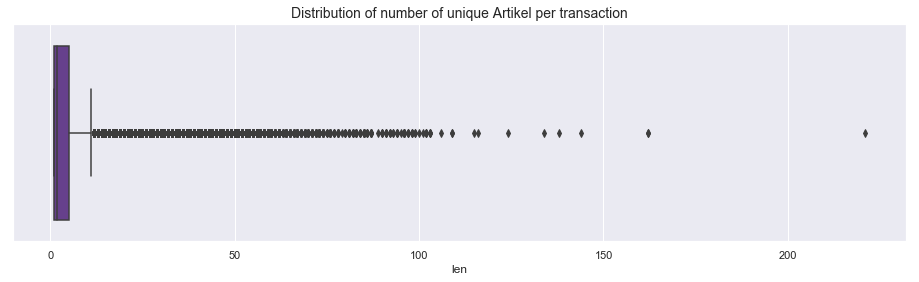

In [11]:
"""Check distribution of number of unique Artikel per transaction"""

transactions['len'] = transactions['Artikel'].apply(len)
print(transactions['len'].value_counts().head(5))

plt.figure(figsize=(16,4))
plt.title("Distribution of number of unique Artikel per transaction", size=14)
sns.boxplot(transactions['len'], color=color, orient='h');

**Findings:** About a third of transactions consist of only 1 product.

In [12]:
transactions.head()

,Artikel,len
0,"[4100130, 5074008, 5250501, 2181201, 6436018]",5
1,"[6436018, 6299907, 6161712]",3
2,"[4921011, 2550805, 6204426, 6115765, 6216191, ...",7
3,"[6634351, 8621604, 6115232, 6204326, 6204426, ...",12
4,"[2119634, 2310306, 6103861, 851403516, 6113401...",9


In [13]:
"""OHE to sparse format with MLxtnd TransactionEncoder"""

te = TransactionEncoder()
products_array = np.array(transactions['Artikel'])
products_array_ohe = te.fit(products_array).transform(products_array, sparse=True)
transactions_sparse = pd.SparseDataFrame(products_array_ohe, 
                                        columns=te.columns_, 
                                        default_fill_value=False)

assert transactions_sparse.iloc[1,].sum() == len(transactions.iloc[1,0])

In [14]:
# Check results
transactions_sparse.head()

,0010074,0013157,0016048,0020058,0020157,0024832,0025064,0025120,0025122,0025123,0025156,0025204,0030766,0040005,0040721,0041083,0041667,0041669,0044744,0045044,0045045,0045065,0045198,0045287,0045293,0045294,0046080,0047458,0048049,0048410,0050314,0053012,0056614,0061855,0064872,0071836,0071950,0072120,0072134,0073481,0077734,0077736,0077942,0079386,0079389,0079568,1041577,1058347,1058348,2003601,...,9149302,9149312,9150462,9150616,9150618,9150619,9150627,9150641,9150642,9150643,9150652,9150653,9163282,9163322,9163330,9163537,9163538,9164364,9164372,9169548,9181742,9181744,9183533,9194935,9194936,9194937,9194967,9204283,9210848,9236718,9238777,9238778,9240575,9240576,9240871,9240872,9240873,9240874,9240927,9240929,9240930,9240931,9240932,9240936,9241049,9241050,9247144,9247529,9900644,9900646
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Get frequent itemsets with Apriori algorithm

**Note:** Due to current limitations in Pandas, if the SparseDataFrame has integer column names,names, please make sure they either start with `0` or cast them as string column names: `df.columns = [str(i) for i in df.columns`].

In [16]:
# transactions_sparse.columns = [str(i) for i in transactions_sparse.columns]

# Set a low min_support to get many sets
frequent_itemsets = apriori(transactions_sparse, min_support=0.001, 
                            use_colnames=True, max_len=None, verbose=1)

Iteration: 1466886 | Sampling itemset size 5


In [17]:
"""Save / Load itemsets for convencience"""

# frequent_itemsets.to_csv('data/interim/frequent_itemsets.csv', index=False)
frequent_itemsets = pd.read_csv('data/interim/frequent_itemsets.csv')

# Check results
frequent_itemsets.info()
display(frequent_itemsets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 2 columns):
support     2143 non-null float64
itemsets    2143 non-null object
dtypes: float64(1), object(1)
memory usage: 33.6+ KB


,support,itemsets
0,0.001279,(0013157)
1,0.002214,(0024832)
2,0.001568,(0025123)
3,0.001420,(0030766)
4,0.001589,(0040721)


**Note:** There is an issue with the frozenset dtype. After saving and reloading the dataframe it gets returned as object and I don't know (yet) how to convert it correctly back to that format while reading in the dataframe.

In [ ]:
# Restore dtype frozenset after Re-Loading
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets']\
        .str.strip('frozenset({})').str.replace("'", "").str.replace(" ", "")
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].str.split(',')
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(frozenset)
assert type(frequent_itemsets['itemsets'][0]) == frozenset

In [18]:
# Add length of individual itemsets (if you later want to filter for length)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [19]:
# Check results
print("Number of frequent sets with support > {}: {}".format(0.001, len(frequent_itemsets))) 
print("Of those, number of sets with more than 1 item:", 
      len(frequent_itemsets.loc[frequent_itemsets['length'] > 1]))

display(frequent_itemsets.tail())

Number of frequent sets with support > 0.001: 2143
Of those, number of sets with more than 1 item: 471


,support,itemsets,length
2138,0.001146,"(8535213, 8535212, 8535211, 8535215)",4
2139,0.001104,"(8535215, 8535212, 8535211, 8535214)",4
2140,0.001090,"(8535213, 8535215, 8535211, 8535214)",4
2141,0.001153,"(8535215, 8535213, 8535212, 8535214)",4
2142,0.001076,"(8535212, 8535214, 8535215, 8535213, 8535211)",5


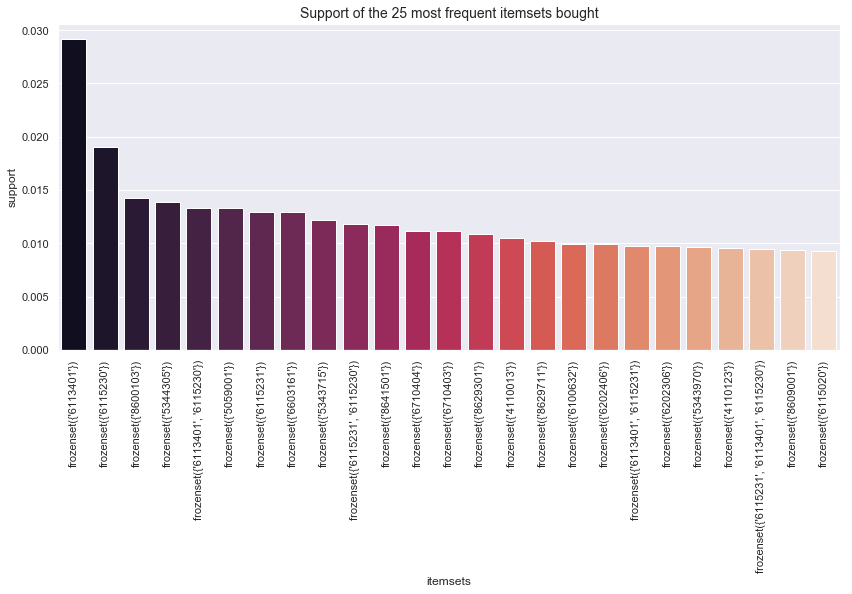

In [20]:
"""Plot support for most frequent item sets / items"""

plt.figure(figsize=(14,6))
plot_df = frequent_itemsets.sort_values(['support'], ascending=False).head(25).reset_index(drop=True)
sns.barplot(y='support', x="itemsets", data=plot_df, palette='rocket')
plt.title("Support of the 25 most frequent itemsets bought", size=14)
plt.xticks(rotation=90);

**Findings:** This bar plot illustrates the item sets / items that are frequently bought at this store, and it is notable that the support of even the most frequent items is relatively low (for example, the most frequent item occurs in only around 3% of transactions). We use these insights to inform the minimum threshold when generating the association rules; for example, we know that in order for the algorithm to return a reasonable number of rules we’ll need to set the support threshold at well below 0.02.

## Generate Association Rules

In [40]:
# Generate rules with min_threshold for lift
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)

In [41]:
# Check results
print(rules.shape)
display(rules.tail())

(972, 9)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
967,(8535212),"(8535213, 8535215, 8535211, 8535214)",0.001828,0.001090,0.001076,0.588462,540.082407,0.001074,2.427259
968,(8535214),"(8535213, 8535212, 8535211, 8535215)",0.001483,0.001146,0.001076,0.725118,632.841596,0.001074,3.633763
969,(8535215),"(8535213, 8535212, 8535211, 8535214)",0.001532,0.001160,0.001076,0.701835,605.096497,0.001074,3.349956
970,(8535213),"(8535215, 8535212, 8535211, 8535214)",0.001638,0.001104,0.001076,0.656652,594.989776,0.001074,2.909286
971,(8535211),"(8535215, 8535213, 8535212, 8535214)",0.001821,0.001153,0.001076,0.590734,512.414564,0.001073,2.440579


Metrics recap:

- **Support**: the percentage of transactions that contain all of the items in an itemset (e.g., pencil, paper and rubber). The higher the support the more frequently the itemset occurs. Rules with a high support are preferred since they are likely to be applicable to a large number of future transactions.(However, there may be instances where a low support is useful if you are trying to find “hidden” relationships.)
- **Confidence**: the probability that a transaction that contains antecedents also contains the consequents. The higher the confidence, the greater the likelihood that the item on the right hand side will be purchased or, in other words, the greater the return rate you can expect for a given rule. (But if it is too high there is not much to optimize.)
- **Lift**: the ratio of the observed support to that expected if the two rules were independent (see wikipedia). The basic rule of thumb is that a lift value close to 1 means the rules were completely independent. The larger the lift the greater the link between the two products.
- **Leverage**: the difference between the observed frequency of antecedents and consequents appearing together and the frequency that would be expected if A and C were independent. An leverage value of 0 indicates independence.
- **Conviction**: a metric that indicates wether the consequent is highly depending on the antecedent. For instance, in the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as 'inf'. Similar to lift, if items are independent, the conviction is 1.

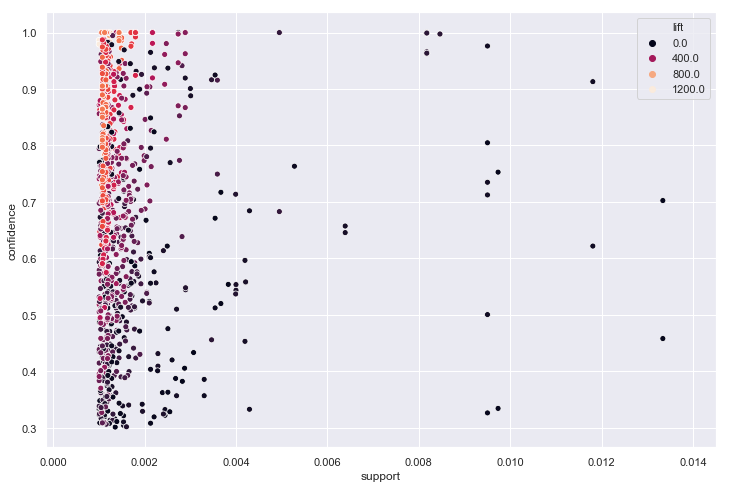

In [42]:
"""Visualize the distribution of the 3 classic metrics"""

plt.figure(figsize=(12,8))
sns.scatterplot('support', 'confidence', data=rules, hue='lift', legend='brief', palette='rocket');

**Findings**:This plot illustrates the relationship between the different metrics. The most interesting rules might be those lying on the “support-confidence boundary”. Essentially, these are the rules that lie on the right hand border of the plot where either support, confidence or both are maximised. The lift is generally really high because the different itemsets are so 'sparse'. On the other had support is really low.

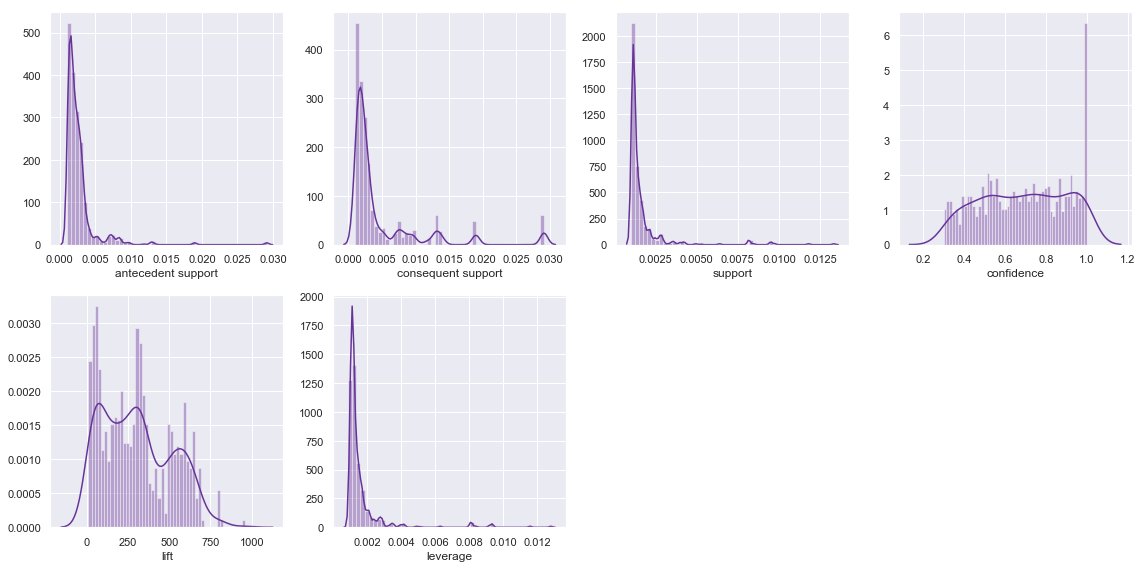

In [47]:
EDA.plot_num_hist(rules.iloc[:,:-1], figsize=(16, 8))

---